# REINFORCE in lasagne (3 pts)

Just like we did before for q-learning, this time we'll design a lasagne network to learn `CartPole-v0` via policy gradient (REINFORCE).

Most of the code in this notebook is taken from Seminar4.0, so you'll find it more or less familiar and even simpler.

__Frameworks__ - we'll accept this homework in any deep learning framework. For example, it translates to TensorFlow almost line-to-line. However, we recommend you to stick to theano/lasagne unless you're certain about your skills in the framework of your choice.

In [1]:
%env THEANO_FLAGS='floatX=float32'
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

env: THEANO_FLAGS='floatX=float32'


[2017-04-01 04:48:42,772] Making new env: CartPole-v0


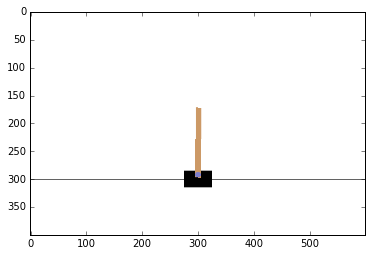

In [2]:
import gym
import numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

env = gym.make("CartPole-v0")
env = env.env
env.reset()
n_actions = env.action_space.n
state_dim = env.observation_space.shape

plt.imshow(env.render("rgb_array"))

# Building the network for REINFORCE

For REINFORCE algorithm, we'll need a model that predicts action probabilities given states.

In [3]:
import theano
import theano.tensor as T

#create input variables. We'll support multiple states at once

states = T.matrix("states[batch,units]")
actions = T.ivector("action_ids[batch]")
cumulative_rewards = T.vector("R[batch] = r + gamma*r' + gamma^2*r'' + ...")

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

[2017-04-01 04:48:44,058] The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GT 730M (CNMeM is enabled with initial size: 70.0% of memory, cuDNN 5110)


In [4]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import rectify, softmax

#input layer
l_states = InputLayer((None,)+state_dim,input_var=states)
layer = DenseLayer(l_states, num_units=128, nonlinearity=rectify)
layer = DenseLayer(layer, num_units=64, nonlinearity=rectify)

#output layer
#this time we need to predict action probabilities,
#so make sure your nonlinearity forces p>0 and sum_p = 1
l_action_probas = DenseLayer(layer,
                             num_units=n_actions,
                             nonlinearity=softmax)

#### Predict function

In [5]:
#get probabilities of actions
predicted_probas = get_output(l_action_probas)

#predict action probability given state
#if you use float32, set allow_input_downcast=True
predict_proba = theano.function(inputs=[states], outputs=predicted_probas, allow_input_downcast=True)

#### Loss function and updates

We now need to define objective and update over policy gradient.

The objective function can be defined thusly:

$$ J \approx \sum  _i log \pi_\theta (a_i | s_i) \cdot R(s_i,a_i) $$

When you compute gradient of that function over network weights $ \theta $, it will become exactly the policy gradient.


In [6]:
#select probabilities for chosen actions, pi(a_i|s_i)
predicted_probas_for_actions = predicted_probas[T.arange(actions.shape[0]),actions]

In [7]:
#REINFORCE objective function
J = T.mean(T.log(predicted_probas_for_actions) * cumulative_rewards)

In [8]:
neg_H = (predicted_probas * T.log(predicted_probas)).sum(axis=-1).mean()

In [9]:
#all network weights
all_weights = get_all_params(l_action_probas)

#weight updates. maximize J = minimize -J
updates = lasagne.updates.sgd(-J + 0.01 * neg_H, all_weights, learning_rate=0.001)

In [10]:
train_step = theano.function([states,actions,cumulative_rewards],updates=updates,
                             allow_input_downcast=True)

### Computing cumulative rewards

In [11]:
def get_cumulative_rewards(rewards, #rewards at each step
                           gamma = 0.99 #discount for reward
                           ):
    """
    take a list of immediate rewards r(s,a) for the whole session 
    compute cumulative rewards R(s,a) (a.k.a. G(s,a) in Sutton '16)
    R_t = r_t + gamma*r_{t+1} + gamma^2*r_{t+2} + ...
    
    The simple way to compute cumulative rewards is to iterate from last to first time tick
    and compute R_t = r_t + gamma*R_{t+1} recurrently
    
    You must return an array/list of cumulative rewards with as many elements as in the initial rewards.
    """
    R = [0]
    for i in range(len(rewards)):
        R.append(rewards[-i-1] + gamma * R[-1])
    return R[::-1][:-1]

In [12]:
assert len(get_cumulative_rewards(range(100))) == 100
assert np.allclose(get_cumulative_rewards([0,0,1,0,0,1,0],gamma=0.9),[1.40049, 1.5561, 1.729, 0.81, 0.9, 1.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,-2,3,-4,0],gamma=0.5), [0.0625, 0.125, 0.25, -1.5, 1.0, -4.0, 0.0])
assert np.allclose(get_cumulative_rewards([0,0,1,2,3,4,0],gamma=0), [0, 0, 1, 2, 3, 4, 0])
print("looks good!")

looks good!


### Playing the game

In [13]:
def generate_session(t_max=1000):
    """play env with REINFORCE agent and train at the session end"""
    
    #arrays to record session
    states,actions,rewards = [],[],[]
    
    s = env.reset()
    
    for t in range(t_max):
        
        #action probabilities array aka pi(a|s)
        action_probas = predict_proba([s])[0] 
        
        a = np.random.choice(n_actions, p=action_probas)
        
        new_s,r,done,info = env.step(a)
        
        #record session history to train later
        states.append(s)
        actions.append(a)
        rewards.append(r)
        
        s = new_s
        if done: break
            
    cumulative_rewards = get_cumulative_rewards(rewards)
    train_step(states,actions,cumulative_rewards)
            
    return sum(rewards)
        

In [14]:
for i in range(100):
    
    rewards = [generate_session() for _ in range(100)] #generate new sessions
    
    print ("mean reward:%.3f"%(np.mean(rewards)))

    if np.mean(rewards) > 300:
        print ("You Win!")
        break

mean reward:19.060
mean reward:21.340
mean reward:21.030
mean reward:24.870
mean reward:24.030
mean reward:30.170
mean reward:30.390
mean reward:27.220
mean reward:27.710
mean reward:31.690
mean reward:29.250
mean reward:32.700
mean reward:33.660
mean reward:28.540
mean reward:32.990
mean reward:40.680
mean reward:35.250
mean reward:38.310
mean reward:39.320
mean reward:42.230
mean reward:40.630
mean reward:48.180
mean reward:49.580
mean reward:45.810
mean reward:53.350
mean reward:54.650
mean reward:59.730
mean reward:59.370
mean reward:71.810
mean reward:68.370
mean reward:71.110
mean reward:82.910
mean reward:91.790
mean reward:95.400
mean reward:105.340
mean reward:95.530
mean reward:122.680
mean reward:138.010
mean reward:161.530
mean reward:169.360
mean reward:184.850
mean reward:162.140
mean reward:207.080
mean reward:150.410
mean reward:148.870
mean reward:170.290
mean reward:146.350
mean reward:144.800
mean reward:139.280
mean reward:123.860
mean reward:142.720
mean reward:235

### Video

In [ ]:
#record sessions
import gym.wrappers
env = gym.wrappers.Monitor(gym.make("CartPole-v0"),directory="videos",force=True)
sessions = [generate_session() for _ in range(100)]
env.close()


In [ ]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./videos/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./videos/"+video_names[-1])) #this may or may not be _last_ video. Try other indices